In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
import scipy
from matplotlib import pyplot as plt

from harmonic_balance import aft, freq, solve, utils

ndarray = np.ndarray

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res.ravel())

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot


f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(10)

In [ ]:
omega = 2
NH = 30
n = 2
N = 128

m1, m2 = 1, 2
c1, c2, c3 = 1, 0.5, 2
k1, k2, k3 = 1, 0.5, 2

M = np.diag([m1, m2])
C = np.array([[c1 + c2, -c2], [-c2, c2 + c3]])
K = np.array([[k1 + k2, -k2], [-k2, k2 + k3]])

ks = (1, 1)
dofs = (0, 1)
is_cosines = (1, 0)
coefficients = (2, 1)
b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

t0, tf = tlim = 0, 2 * np.pi / omega
tn = NH * 2
tls = np.linspace(*tlim, tn, endpoint=False)

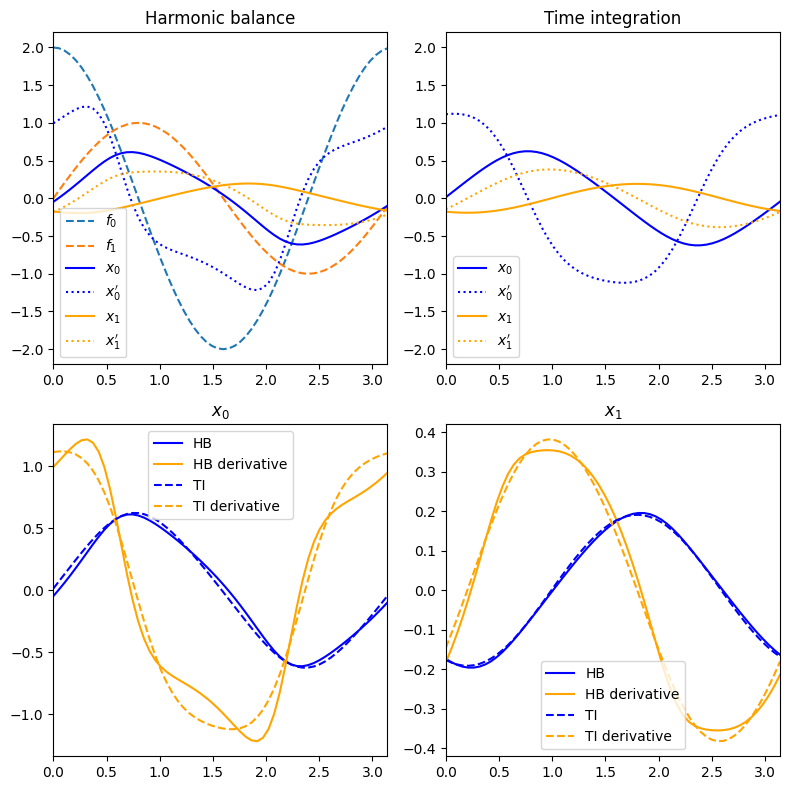

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
colors = ("blue", "orange")

ax = axs[0, 0]
ax.set_title("Harmonic balance")

bb_ext = utils.extract_dofs_freq(b_ext, n)
ff = scipy.fft.irfft(bb_ext.toarray(), axis=1, norm=freq.FFT_NORM)
names = [rf"f_{i}" for i in range(n)]
for f, color, name in zip(ff, colors, names):
    ax.plot(tls, f, label=f"${name}$", ls="--")

A = freq.get_A(omega, NH, M, C, K)
z0 = freq.solve_linear_system(A, b_ext)
z, *_ = solve.solve_nonlinear(
    omega, z0, A, b_ext, f_nl, df_nl_dx, df_nl_d_xdot, NH, n, N
)
zp = freq.get_derivative(omega, z, NH, n)

zz = utils.extract_dofs_freq(z, n)
zzp = utils.extract_dofs_freq(zp, n)

xx = scipy.fft.irfft(zz, axis=1, norm=freq.FFT_NORM)
xxp = scipy.fft.irfft(zzp, axis=1, norm=freq.FFT_NORM)

names = [rf"x_{i}" for i in range(n)]
for x, xp, color, name in zip(xx, xxp, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()

ax = axs[0, 1]
ax.set_title("Time integration")

x0 = xx[:, 0]
xp0 = xxp[:, 0]
y0 = np.concat((x0, xp0))


def get_f_ext(n, ks, dofs, is_cosines, coefficients):
    def f_ext(omega, t):
        res = np.zeros(n)
        for k, dof, is_cosine, coefficient in zip(
            ks, dofs, is_cosines, coefficients
        ):
            if k == 0:
                res[dof] += coefficient
            elif is_cosine:
                res[dof] += coefficient * np.cos(k * omega * t)
            else:
                res[dof] += coefficient * np.sin(k * omega * t)
        return res

    return f_ext


def ode(t, y, *args):
    omega, M, C, K, f_ext, f_nl = args

    x = y[:n]
    xp = y[n:]

    xpp = np.linalg.inv(M) @ (
        -C @ xp - K @ x - f_nl(x, xp, 1) + f_ext(omega, t)
    )
    return np.concat((xp, xpp))


total_periods = 500
period = 2 * np.pi / omega
ti_t0, ti_tf = ti_tlim = t0, total_periods * period
ti_tls = np.linspace(ti_tf - period, ti_tf, tn, endpoint=False)

f_ext = get_f_ext(n, ks, dofs, is_cosines, coefficients)
args = (omega, M, C, K, f_ext, f_nl)
sol = scipy.integrate.solve_ivp(
    ode, ti_tlim, y0, t_eval=ti_tls, args=args, atol=1e-10, rtol=1e-10
)

xx_ti = sol.y[:n]
xxp_ti = sol.y[n:]

for x, xp, color, name in zip(xx_ti, xxp_ti, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()
ax.set_ylim(axs[0, 0].get_ylim())

for i in range(n):
    ax = axs[1, i]
    ax.set_title(rf"${names[i]}$")
    ax.plot(tls, xx[i], color=colors[0], label="HB")
    ax.plot(tls, xxp[i], color=colors[1], label="HB derivative")
    ax.plot(tls, xx_ti[i], color=colors[0], label="TI", ls="--")
    ax.plot(tls, xxp_ti[i], color=colors[1], label="TI derivative", ls="--")
    ax.legend()

[ax.set_xlim(*tlim) for ax in axs.ravel()]

fig.tight_layout()
plt.show()

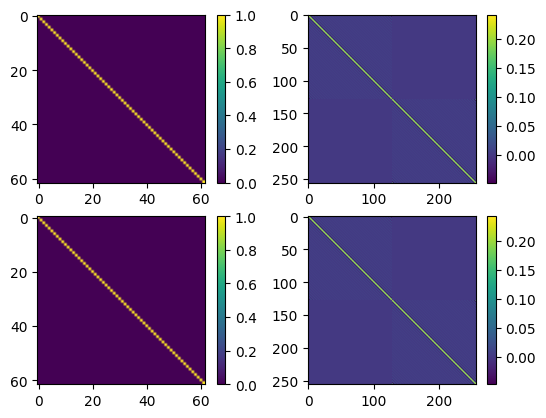

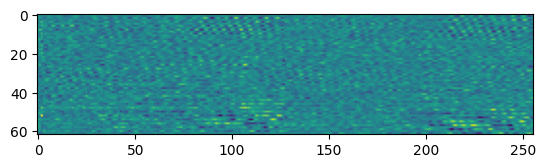

(np.float64(5.3980848509984426e-15),
 np.float64(4.6781282181946465e-17),
 np.float64(8.409160753730258e-15),
 np.float64(6.254634441385502e-17))

In [ ]:
gamma = aft.get_gamma(omega, NH, n, N)
inv_gamma = aft.get_inv_gamma(omega, NH, n, N)

fig, axs = plt.subplots(2, 2)
images = list()
np_inv_gamma = np.linalg.pinv(gamma.toarray())
images.append(axs[0, 0].imshow((np_inv_gamma @ gamma).real))
images.append(axs[0, 1].imshow((gamma @ np_inv_gamma).real))
images.append(axs[1, 0].imshow((inv_gamma @ gamma).real.toarray()))
images.append(axs[1, 1].imshow((gamma @ inv_gamma).real.toarray()))
[fig.colorbar(image) for image in images]
plt.show()

plt.imshow((inv_gamma - np.linalg.pinv(gamma.toarray())).real)
plt.show()


(
    utils.max_abs(gamma @ np_inv_gamma @ gamma - gamma),
    utils.max_abs(np_inv_gamma @ gamma @ np_inv_gamma - np_inv_gamma),
    utils.max_abs(gamma @ inv_gamma @ gamma - gamma),
    utils.max_abs(inv_gamma @ gamma @ inv_gamma - inv_gamma),
)

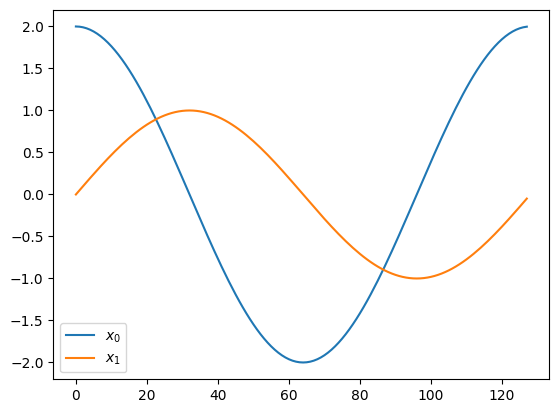

np.float64(1.7615132494473541e-15)

In [ ]:
time = aft.time_from_freq(n, gamma, b_ext)
x0, x1 = utils.extract_dofs_time(time, n)
plt.plot(x0.toarray(), label="$x_0$")
plt.plot(x1.toarray(), label="$x_1$")
plt.legend()
plt.show()

utils.max_abs(aft.freq_from_time(inv_gamma, time) - b_ext)